In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anksin88","key":"3648c618334f629235908b21668740fb"}'}

In [ ]:
#Create Kaggle directory to store the key
!mkdir ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download data set from Kaggle
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [04:36<00:00, 43.1MB/s]
100% 9.51G/9.51G [04:36<00:00, 37.0MB/s]


In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Create a folder and extract the downloaded zip dataset
!mkdir -p "/content/drive/My Drive/AA2_Project_APTOS2019/"

In [ ]:
import zipfile
import os

# Set the path in Google Drive
dataset_path = "/content/drive/My Drive/AA2_Project_APTOS2019/"

# Create the directory if not exists
os.makedirs(dataset_path, exist_ok=True)

# Extract dataset to Google Drive
with zipfile.ZipFile("aptos2019-blindness-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print("Dataset extracted to:", dataset_path)

Dataset extracted to: /content/drive/My Drive/AA2_Project_APTOS2019/


In [ ]:
# Set paths for the CSV files
train_csv_path = "/content/drive/MyDrive/AA2_Project_APTOS2019/train.csv"

# Set path for images
train_images_path = "/content/drive/MyDrive/AA2_Project_APTOS2019/train_images/"

In [ ]:
!pip install torch torchvision pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
# Load CSV file
train_df = pd.read_csv(train_csv_path)
print(train_df.head())  # Show first few rows

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [ ]:
# Split train data into train and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(train_df))
val_size = len(train_df) - train_size
train_indices, val_indices = random_split(range(len(train_df)), [train_size, val_size])

# Convert indices to DataFrame slices
train_df_split = train_df.iloc[list(train_indices)].reset_index(drop=True)
val_df_split = train_df.iloc[list(val_indices)].reset_index(drop=True)

# Define dataset class
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class EyeDataset(Dataset):
    def __init__(self, dataframe, image_path, transform=default_transform):
        self.df = dataframe
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0] + ".png"
        img_path = os.path.join(self.image_path, img_name)
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx, 1])  # Ensure label is integer
        if self.transform:
            image = self.transform(image)
        return image, label

# Create data loaders
batch_size = 32
train_dataset = EyeDataset(train_df_split, train_images_path)
val_dataset = EyeDataset(val_df_split, train_images_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Train function
def train_model(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    return model


In [ ]:
# Function for average ensemble with confusion matrix
def average_ensemble_predict(resnet_model, efficientnet_model, val_loader, device):
    resnet_model.eval()
    efficientnet_model.eval()

    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Get softmax probabilities from both models
            resnet_probs = F.softmax(resnet_model(images), dim=1)
            efficientnet_probs = F.softmax(efficientnet_model(images), dim=1)

            # Average probabilities
            avg_probs = (resnet_probs + efficientnet_probs) / 2

            # Get final predicted class
            final_preds = torch.argmax(avg_probs, dim=1)

            correct += (final_preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(final_preds.cpu().numpy())

    print(f'Average Ensemble Validation Accuracy: {100 * correct / total:.2f}%')

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Average Ensemble')
    plt.show()

In [ ]:
# Function for weighted averaging ensemble with confusion matrix
def weighted_ensemble_predict(resnet_model, efficientnet_model, val_loader, device, w1=0.6, w2=0.4):
    resnet_model.eval()
    efficientnet_model.eval()

    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Get softmax probabilities from both models
            resnet_probs = F.softmax(resnet_model(images), dim=1)
            efficientnet_probs = F.softmax(efficientnet_model(images), dim=1)

            # Weighted average of probabilities
            weighted_probs = (w1 * resnet_probs) + (w2 * efficientnet_probs)

            # Get final predicted class
            final_preds = torch.argmax(weighted_probs, dim=1)

            correct += (final_preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(final_preds.cpu().numpy())

    print(f'Weighted Ensemble Validation Accuracy: {100 * correct / total:.2f}%')

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Weighted Ensemble')
    plt.show()

In [ ]:
# Load pretrained models RESNET50
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [ ]:
# Load pretrained models EFFICIENTNET
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 5)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 21.3MB/s]


In [ ]:
# Evaluate function
def evaluate_model(model, val_loader):
    model.eval()
    model = model.to(device)
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds)

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Training ResNet-50...


100%|██████████| 92/92 [07:26<00:00,  4.85s/it]


Epoch [1/12], Loss: 0.6806, Train Acc: 0.7552


100%|██████████| 92/92 [07:03<00:00,  4.60s/it]


Epoch [2/12], Loss: 0.4896, Train Acc: 0.8187


100%|██████████| 92/92 [07:00<00:00,  4.57s/it]


Epoch [3/12], Loss: 0.4375, Train Acc: 0.8358


100%|██████████| 92/92 [07:00<00:00,  4.57s/it]


Epoch [4/12], Loss: 0.3795, Train Acc: 0.8610


100%|██████████| 92/92 [06:58<00:00,  4.55s/it]


Epoch [5/12], Loss: 0.3045, Train Acc: 0.8843


100%|██████████| 92/92 [07:01<00:00,  4.59s/it]


Epoch [6/12], Loss: 0.2867, Train Acc: 0.8907


100%|██████████| 92/92 [06:59<00:00,  4.56s/it]


Epoch [7/12], Loss: 0.2240, Train Acc: 0.9198


100%|██████████| 92/92 [06:59<00:00,  4.56s/it]


Epoch [8/12], Loss: 0.1949, Train Acc: 0.9327


100%|██████████| 92/92 [06:59<00:00,  4.56s/it]


Epoch [9/12], Loss: 0.1636, Train Acc: 0.9403


100%|██████████| 92/92 [06:57<00:00,  4.53s/it]


Epoch [10/12], Loss: 0.1313, Train Acc: 0.9583


100%|██████████| 92/92 [07:01<00:00,  4.58s/it]


Epoch [11/12], Loss: 0.1098, Train Acc: 0.9669


100%|██████████| 92/92 [07:06<00:00,  4.64s/it]


Epoch [12/12], Loss: 0.0975, Train Acc: 0.9703
Validation Accuracy: 81.45%
Confusion Matrix:
 [[355   4   1   0   0]
 [ 13  50  23   0   4]
 [  6  10 154  13  14]
 [  0   0  15  13   5]
 [  1   1  24   2  25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       360
           1       0.77      0.56      0.65        90
           2       0.71      0.78      0.74       197
           3       0.46      0.39      0.43        33
           4       0.52      0.47      0.50        53

    accuracy                           0.81       733
   macro avg       0.68      0.64      0.66       733
weighted avg       0.81      0.81      0.81       733



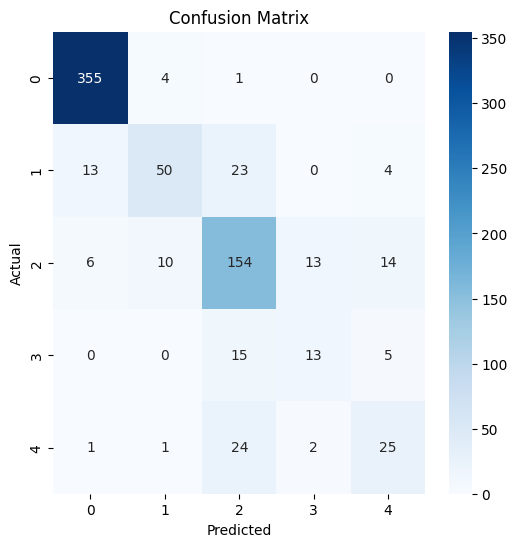

In [ ]:
print("Training ResNet-50...")
resnet_model = train_model(resnet_model, train_loader, val_loader, epochs=12)
evaluate_model(resnet_model, val_loader)

Training EfficientNet...


100%|██████████| 92/92 [06:50<00:00,  4.46s/it]


Epoch [1/12], Loss: 0.6883, Train Acc: 0.7521


100%|██████████| 92/92 [06:35<00:00,  4.30s/it]


Epoch [2/12], Loss: 0.5003, Train Acc: 0.8088


100%|██████████| 92/92 [06:36<00:00,  4.31s/it]


Epoch [3/12], Loss: 0.4151, Train Acc: 0.8467


100%|██████████| 92/92 [06:36<00:00,  4.30s/it]


Epoch [4/12], Loss: 0.3514, Train Acc: 0.8774


100%|██████████| 92/92 [06:38<00:00,  4.33s/it]


Epoch [5/12], Loss: 0.2739, Train Acc: 0.8996


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch [6/12], Loss: 0.2126, Train Acc: 0.9256


100%|██████████| 92/92 [06:37<00:00,  4.32s/it]


Epoch [7/12], Loss: 0.2070, Train Acc: 0.9235


100%|██████████| 92/92 [06:37<00:00,  4.33s/it]


Epoch [8/12], Loss: 0.1965, Train Acc: 0.9317


100%|██████████| 92/92 [06:35<00:00,  4.30s/it]


Epoch [9/12], Loss: 0.1408, Train Acc: 0.9478


100%|██████████| 92/92 [06:35<00:00,  4.30s/it]


Epoch [10/12], Loss: 0.1386, Train Acc: 0.9539


100%|██████████| 92/92 [06:34<00:00,  4.29s/it]


Epoch [11/12], Loss: 0.1209, Train Acc: 0.9587


100%|██████████| 92/92 [06:36<00:00,  4.31s/it]


Epoch [12/12], Loss: 0.1000, Train Acc: 0.9645
Validation Accuracy: 83.49%
Confusion Matrix:
 [[357   3   0   0   0]
 [  9  52  25   0   4]
 [  1  12 161  11  12]
 [  0   0  14  12   7]
 [  0   2  12   9  30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       360
           1       0.75      0.58      0.65        90
           2       0.76      0.82      0.79       197
           3       0.38      0.36      0.37        33
           4       0.57      0.57      0.57        53

    accuracy                           0.83       733
   macro avg       0.69      0.66      0.67       733
weighted avg       0.83      0.83      0.83       733



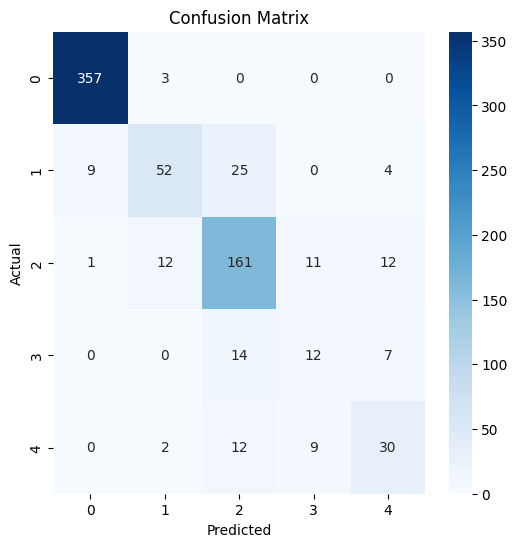

In [ ]:
print("Training EfficientNet...")
efficientnet_model = train_model(efficientnet_model, train_loader, val_loader, epochs=12)
evaluate_model(efficientnet_model, val_loader)


Running Average Ensemble...
Average Ensemble Validation Accuracy: 84.45%

Confusion Matrix:
[[356   4   0   0   0]
 [ 12  49  25   0   4]
 [  1  11 170   8   7]
 [  0   0  14  14   5]
 [  0   2  16   5  30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       360
           1       0.74      0.54      0.63        90
           2       0.76      0.86      0.81       197
           3       0.52      0.42      0.47        33
           4       0.65      0.57      0.61        53

    accuracy                           0.84       733
   macro avg       0.73      0.68      0.70       733
weighted avg       0.84      0.84      0.84       733



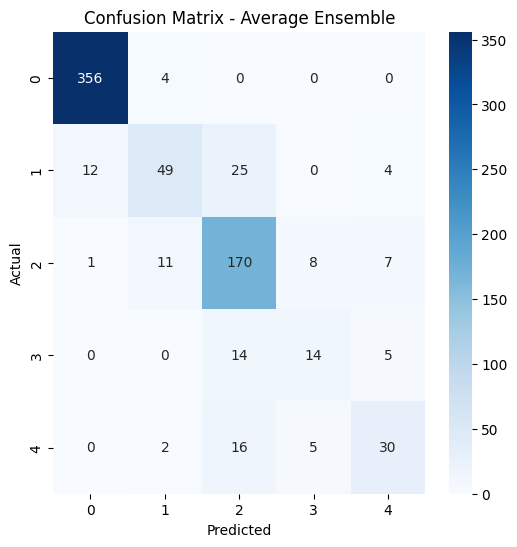

In [ ]:
# Run ensemble predictions with confusion matrices
print("\nRunning Average Ensemble...")
average_ensemble_predict(resnet_model, efficientnet_model, val_loader, device)


Running Weighted Ensemble...
Weighted Ensemble Validation Accuracy: 83.49%

Confusion Matrix:
[[357   3   0   0   0]
 [ 14  48  24   0   4]
 [  3   9 168   8   9]
 [  0   0  16  12   5]
 [  1   2  19   4  27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       360
           1       0.77      0.53      0.63        90
           2       0.74      0.85      0.79       197
           3       0.50      0.36      0.42        33
           4       0.60      0.51      0.55        53

    accuracy                           0.83       733
   macro avg       0.71      0.65      0.67       733
weighted avg       0.83      0.83      0.83       733



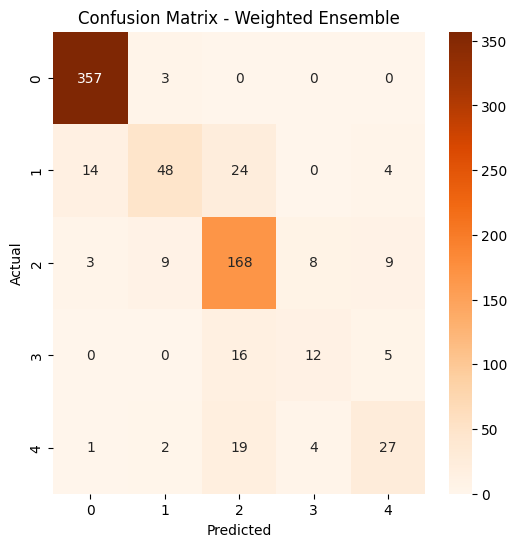

In [ ]:
print("\nRunning Weighted Ensemble...")
weighted_ensemble_predict(resnet_model, efficientnet_model, val_loader, device, w1=0.6, w2=0.4)


Running Weighted Ensemble with higher weightage to EfficientNet...
Weighted Ensemble Validation Accuracy: 84.17%

Confusion Matrix:
[[357   3   0   0   0]
 [ 12  50  25   0   3]
 [  1  10 165  11  10]
 [  0   0  13  15   5]
 [  0   3  12   8  30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       360
           1       0.76      0.56      0.64        90
           2       0.77      0.84      0.80       197
           3       0.44      0.45      0.45        33
           4       0.62      0.57      0.59        53

    accuracy                           0.84       733
   macro avg       0.71      0.68      0.69       733
weighted avg       0.84      0.84      0.84       733



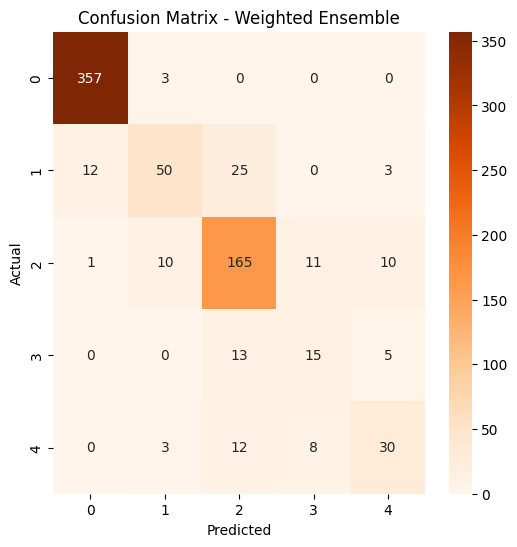

In [ ]:
print("\nRunning Weighted Ensemble with higher weightage to EfficientNet...")
weighted_ensemble_predict(resnet_model, efficientnet_model, val_loader, device, w1=0.4, w2=0.6)